# Dual-component working memory (DCWM)
## A Cue-Based Memory Binding task
## FF controller: input+interface/512/1024/512/output+interface
## Random Network forget_rate=1/3, net_size=1000, degree=20, interface_dim=350

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from model import DCWM
from trainer import trainer

import pickle
import dill

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Generate or Loading training data

In [2]:
cols = 8 # two bits for context
remembered = 2 # doesnt work with other number must change y by yourself
n = 3000 # all posible sequences is (2^7)*(2^6)=8192 , probability of new in and validation & test is 60%

In [3]:
#for first x and y
x=np.random.randint(0,2,(1,1,cols))
x[0,0,0]=0 #0 for task1 ,and 1 for task2
x[0,0,1]=0 #0 for task1 ,and 1 for task2
temp=np.zeros((1,1,remembered*(cols-2)))
temp[0,0,:cols-2]=x[0,0,2:]
y=temp
########################################################################

for i in range(n):
    temp=np.random.randint(0,2,(1,1,cols))
    x=np.append(x,temp,axis=0)

t2= np.full(x.shape, 1)
x[::10,:,:2]=t2[::10,:,:2]

for i in range(n):
    if (x[i+1,0,0]==0):
        x[i+1,0,1]=0
        t1=np.zeros((1,1,cols-2))
        t2=np.zeros((1,1,cols-2))
        t1[0,0,:]=x[i+1,0,2:]
        t2[0,0,:]=x[i,0,2:]
        temp=np.concatenate((t1[0],t2[0]),axis=1)
        y=np.append(y,temp.reshape(1,1,(cols-2)*remembered),axis=0)
        
    else:
        x[i+1,0,1]=1
        t1=np.zeros((1,1,cols-2))
        t2=np.zeros((1,1,cols-2))
        t1[0,0,:]=x[i+1,0,2:]
        t2[0,0,:]=x[i-1,0,2:]
        temp=np.concatenate((t1[0],t2[0]),axis=1)
        y=np.append(y,temp.reshape(1,1,(cols-2)*remembered),axis=0)



########################################################################
y[0,0,cols-2:]=x[-1,0,2:]


### X

In [4]:
#x

## Y

In [5]:
#y

### save data

In [6]:
#saving train set for first run
#This section must deactivate when you want loading
#dill.dump(x, file = open("x.pickle", "wb"))
#dill.dump(y, file = open("y.pickle", "wb"))

In [7]:
#loading train set for next runs
#This section must deactivate when you want new train
x=dill.load(open("x.pickle", "rb"))
y=dill.load(open("y.pickle", "rb"))

### see data format

In [8]:
np.shape(x)

(3001, 1, 8)

In [9]:
np.shape(y)

(3001, 1, 12)

In [10]:
n_1=0
n_2=0

for i in range(n+1):
    if (x[i,0,0]==1):
        n_2=n_2+1   
    else:
        n_1=n_1+1

In [11]:
(n_1,n_2)

(1339, 1662)

# Validation Data

In [12]:
n_val =400

In [13]:
#for first x_val and y_val
x_test=np.random.randint(0,2,(1,1,cols))
x_test[0,0,0]=0 #0 for task1 ,and 1 for task2
x_test[0,0,1]=0 #0 for task1 ,and 1 for task2
temp=np.zeros((1,1,remembered*(cols-2)))
temp[0,0,:cols-2]=x_test[0,0,2:]
y_test=temp
y_test[0,0,cols-2:]=x[-1,0,2:]

########################################################################

for i in range(n_val):
    temp=np.random.randint(0,2,(1,1,cols))
    x_test=np.append(x_test,temp,axis=0)

for i in range(n_val):
    if (x_test[i+1,0,0]==0):
        x_test[i+1,0,1]=0
        t1=np.zeros((1,1,cols-2))
        t2=np.zeros((1,1,cols-2))
        t1[0,0,:]=x_test[i+1,0,2:]
        t2[0,0,:]=x_test[i,0,2:]
        temp=np.concatenate((t1[0],t2[0]),axis=1)
        y_test=np.append(y_test,temp.reshape(1,1,(cols-2)*remembered),axis=0)
        
    else:
        x_test[i+1,0,1]=1
        t1=np.zeros((1,1,cols-2))
        t2=np.zeros((1,1,cols-2))
        t1[0,0,:]=x_test[i+1,0,2:]
        t2[0,0,:]=x_test[i-1,0,2:]
        temp=np.concatenate((t1[0],t2[0]),axis=1)
        y_test=np.append(y_test,temp.reshape(1,1,(cols-2)*remembered),axis=0)



########################################################################
if (x_test[1,0,0]==1):
    y_test[1,0,cols-2:]=x[0,0,2:]
    
y[0,0,cols-2:]=x_test[-1,0,2:]

if (x[1,0,0]==1):
    y[1,0,cols-2:]=x_test[0,0,2:]

In [14]:
#x_test

In [15]:
#saving train set for first run
#This section must deactivate when you want loading
#dill.dump(x_test, file = open("x_test.pickle", "wb"))
#dill.dump(y_test, file = open("y_test.pickle", "wb"))

In [16]:
#loading train set for next runs
#This section must deactivate when you want new train
x_test=dill.load(open("x_test.pickle", "rb"))
y_test=dill.load(open("y_test.pickle", "rb"))
x_val_last=x_test[-1,0,2:] #we use it later

In [17]:
np.shape(y_test)

(401, 1, 12)

In [18]:
n_1=0
n_2=0

for i in range(n_val+1):
    if (x_test[i,0,0]==1):
        n_2=n_2+1   
    else:
        n_1=n_1+1

In [19]:
(n_1,n_2)

(190, 211)

## Initialize and train model

Initialize or loading:

In [20]:
interface_vactor_dim=350 #defult

In [21]:
dcwm = DCWM(input_dim=cols,output_dim=2*(cols-2),controller_dime=512,interface_dim=interface_vactor_dim,netsize=1000)
history=[]

c_a=[]

In [22]:
#Loading model and history
#This section must deactivate when you want new train
dcwm= dill.load(open("trained_dcwm.pickle", "rb"))
history= dill.load(open("history.pickle", "rb"))
c_a=dill.load(open("c_a.pickle", "rb"))

Train:

In [23]:
n=0 #set 0 in loading the model and 5 for the train
lastnum=0 #last number of last run shows in previous step and saved
epochsnum=1

In [24]:
#I use loop because I dont have powerfull device to run whole epochs at ones and 
#I need save and check point in each round

for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)
    
    
    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))
    
    #Validation
    y_temp , v0 = dcwm(x_test[0]) 
    y_pred=y_temp.numpy().reshape(1,2*(cols-2))
    i2=1
    while i2 < n_val+1:
        y_pred_temp , v0 = dcwm(x_test[i2]) 
        y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,2*(cols-2)),0)
        i2=i2+1
    
    y_decide=np.zeros(y_pred.shape)
    for i2 in range(2*(cols-2)):
        for j2 in range(n_val):
            if y_pred[j2,i2]>(1/2) : # thereshold 0.5
                y_decide[j2,i2]=1
    
    
    counter=np.zeros((1,np.size(x_test[:,0,0])))
    
    for i2 in range(2*(cols-2)):
        for j2 in range(n_val+1):
            if (y_decide[j2,i2]!=y_test[j2,0,i2]):
                counter[0,j2]=counter[0,j2]+1
                
    if (c_a==[]): #TF raises the error for this line!
        c_a=counter
    else:
        c_a=np.append(c_a,counter, axis=0)
    
    dill.dump(c_a, file = open("c_a.pickle", "wb"))
    

In [25]:
n=0 #set 0 in loading the model 10 for the train
lastnum=5 #last number of last run shows in previous step and saved 
epochsnum=1

In [26]:
#I use loop because I dont have powerfull device to run whole epochs at ones and 
#I need save and check point in each round

for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)
    
    
    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))
    
    #Validation
    y_temp , v0 = dcwm(x_test[0]) 
    y_pred=y_temp.numpy().reshape(1,2*(cols-2))
    i2=1
    while i2 < n_val+1:
        y_pred_temp , v0 = dcwm(x_test[i2]) 
        y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,2*(cols-2)),0)
        i2=i2+1
    
    y_decide=np.zeros(y_pred.shape)
    for i2 in range(2*(cols-2)):
        for j2 in range(n_val):
            if y_pred[j2,i2]>(1/2) : # thereshold 0.5
                y_decide[j2,i2]=1
    
    
    counter=np.zeros((1,np.size(x_test[:,0,0])))
    
    for i2 in range(2*(cols-2)):
        for j2 in range(n_val+1):
            if (y_decide[j2,i2]!=y_test[j2,0,i2]):
                counter[0,j2]=counter[0,j2]+1
                
    if (c_a==[]): #TF raises the error for this line!
        c_a=counter
    else:
        c_a=np.append(c_a,counter, axis=0)
    
    dill.dump(c_a, file = open("c_a.pickle", "wb"))
    

In [27]:
n=0 #set 0 for loading and 5 for the train
lastnum=15 #last number of last run shows
epochsnum=1

In [28]:
#I use loop because I dont have powerfull device to run whole epochs at ones and 
#I need save and check point in each round

for i in range(n):
    h=trainer(
        model=dcwm,
        loss_fn=tf.keras.losses.mse,
        X_train=x,
        y_train=y,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6),
        epochs=epochsnum,
        batch_size=1,
        verbose=True)
    
    print((i+1)*epochsnum+lastnum)
    history=np.append(history,h)
    
    
    #save model
    dill.dump(dcwm, file = open("trained_dcwm.pickle", "wb"))
    dill.dump(history, file = open("history.pickle", "wb"))
    
    #Validation
    y_temp , v0 = dcwm(x_test[0]) 
    y_pred=y_temp.numpy().reshape(1,2*(cols-2))
    i2=1
    while i2 < n_val+1:
        y_pred_temp , v0 = dcwm(x_test[i2]) 
        y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,2*(cols-2)),0)
        i2=i2+1
    
    y_decide=np.zeros(y_pred.shape)
    for i2 in range(2*(cols-2)):
        for j2 in range(n_val):
            if y_pred[j2,i2]>(1/2) : # thereshold 0.5
                y_decide[j2,i2]=1
    
    
    counter=np.zeros((1,np.size(x_test[:,0,0])))
    
    for i2 in range(2*(cols-2)):
        for j2 in range(n_val+1):
            if (y_decide[j2,i2]!=y_test[j2,0,i2]):
                counter[0,j2]=counter[0,j2]+1
                
    if (c_a==[]): #TF raises the error for this line!
        c_a=counter
    else:
        c_a=np.append(c_a,counter, axis=0)
    
    dill.dump(c_a, file = open("c_a.pickle", "wb"))
    

## History and Convergence

In [29]:
#history

In [30]:
np.size(history)
xyz=np.zeros(np.size(history))
for i in range(np.size(history)):
    xyz[i]=i

<IPython.core.display.Javascript object>


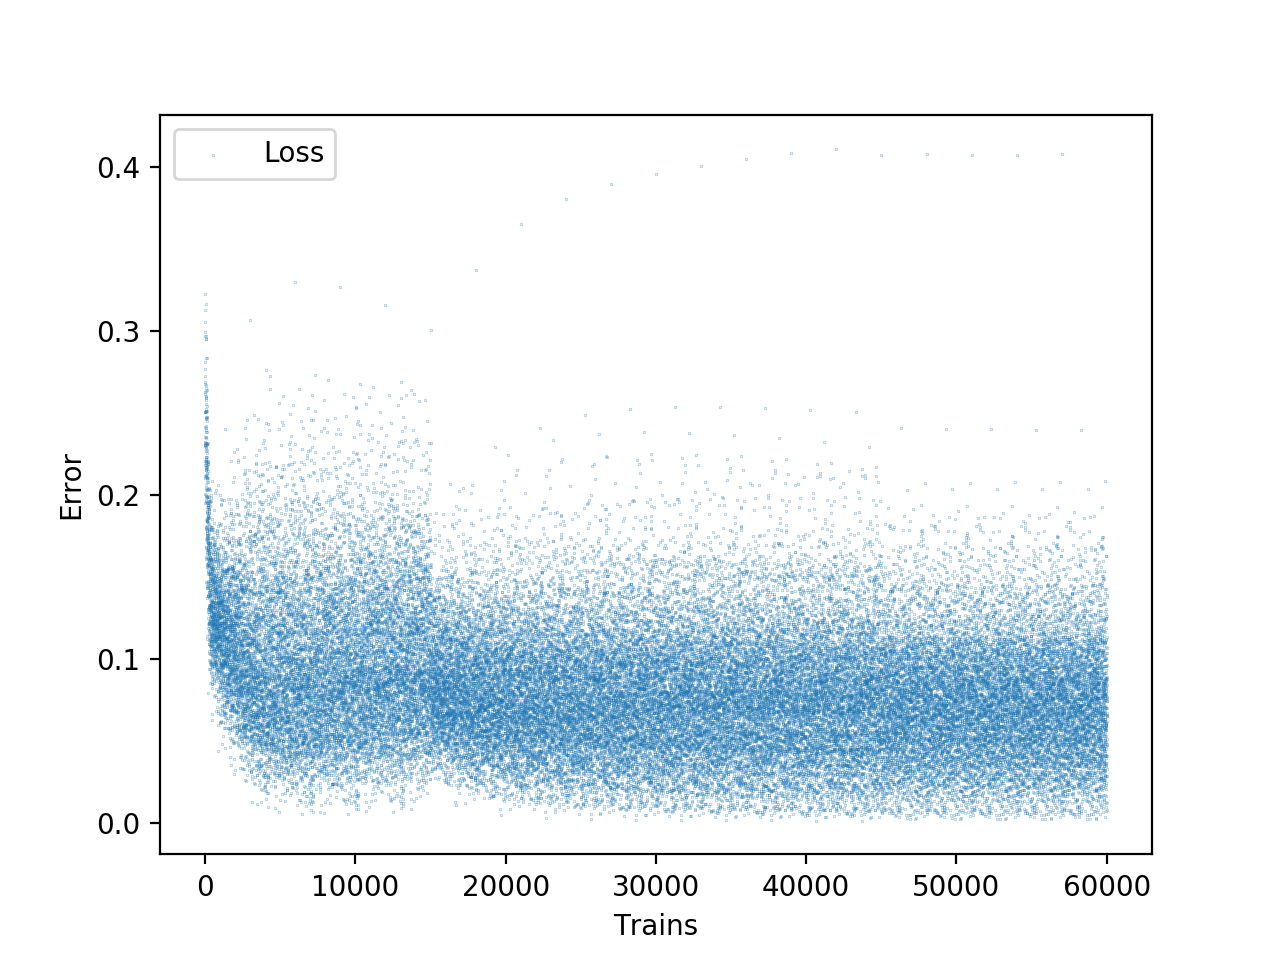

In [31]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600) #saving image with high quality

plt.scatter(xyz, history,0.01 ,label='Loss')
plt.xlabel('Trains')
plt.ylabel('Error')
plt.legend()
plt.show()

#fig.savefig('MultiOrderBindingTaskConvergencetrains.png')

<IPython.core.display.Javascript object>


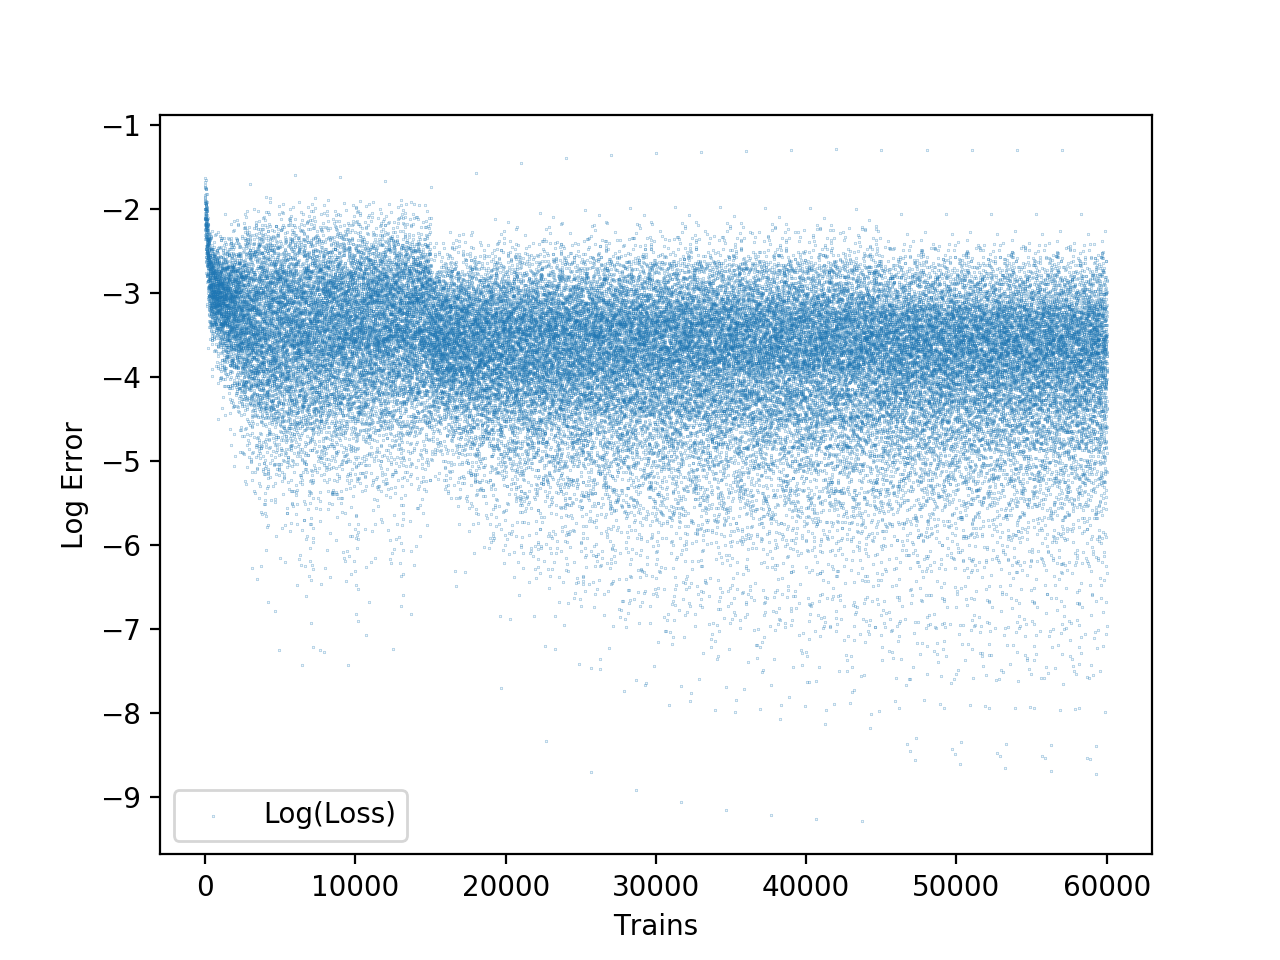

In [32]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600) #saving image with high quality

plt.scatter(xyz, np.log2(history),0.01 ,label='Log(Loss)')
plt.xlabel('Trains')
plt.ylabel('Log Error')
plt.legend()
plt.show()

#fig.savefig('MULTIBindingTaskLOGConvergencetrains.png')

In [33]:
CoE=np.zeros(np.size(history)-100)
for i in range(np.size(history)-100):
    CoE[i]=np.sum(history[i:i+100])/100

<IPython.core.display.Javascript object>


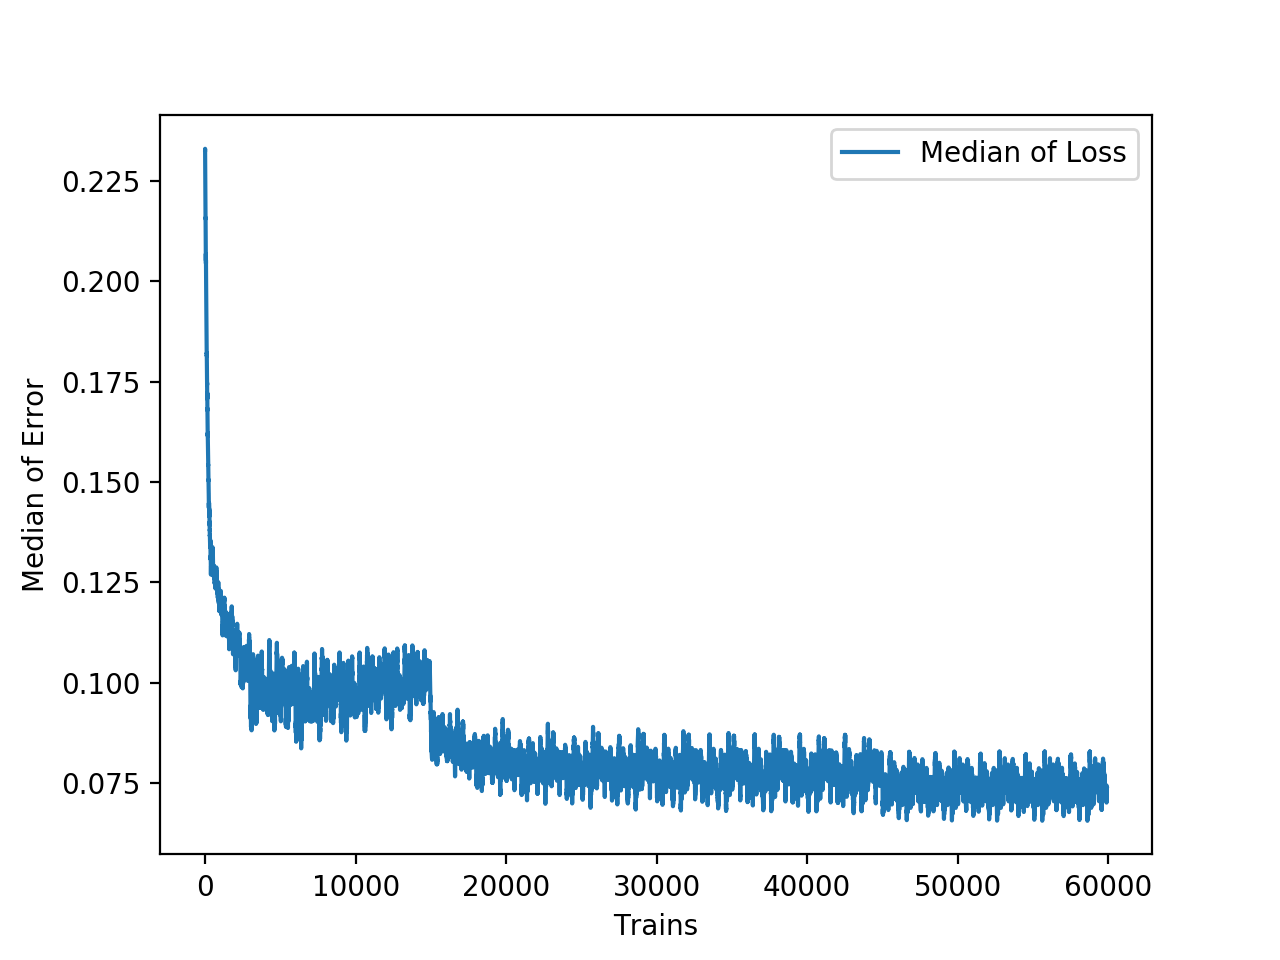

In [34]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600)

plt.plot(CoE,label='Median of Loss')
plt.xlabel('Trains')
plt.ylabel('Median of Error')
plt.legend()
plt.show()

#fig.savefig('convergence for median of loss.png')

In [35]:
CoE2=np.zeros(np.size(history)-100)
for i in range(np.size(history)-100):
    CoE2[i]=np.sum(np.log2(history[i:i+100]))/100

<IPython.core.display.Javascript object>


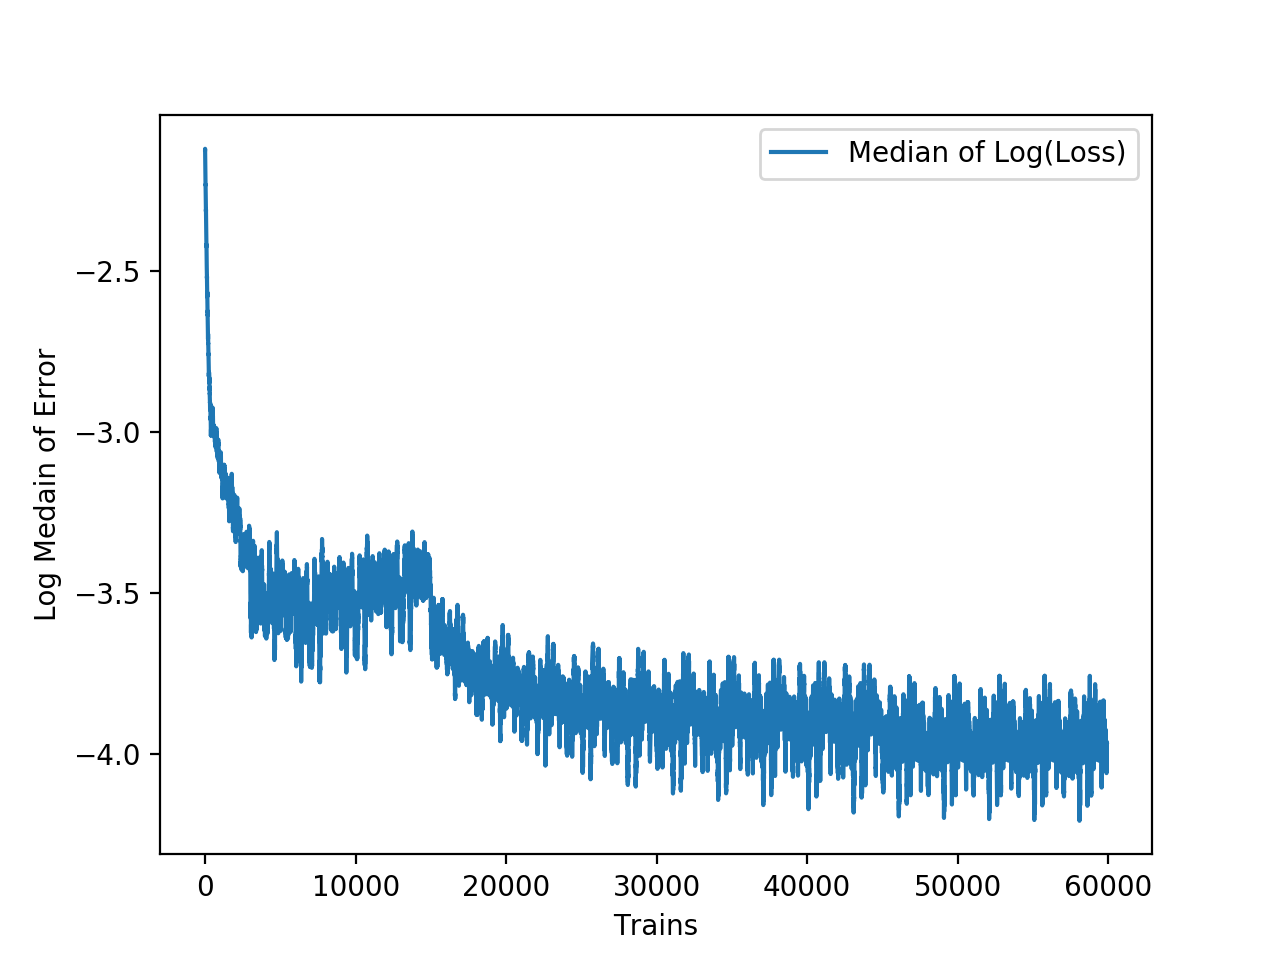

In [36]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600)

plt.plot(CoE2,label='Median of Log(Loss)')
plt.xlabel('Trains')
plt.ylabel('Log Medain of Error')
plt.legend()
plt.show()

#fig.savefig('convergence for median of Logloss.png')

# Valdation Graph

In [37]:
#the number of taken validation test
np.size(c_a[:,0])

20

In [38]:
#c_a

In [39]:
counter1=0
counter2=0

for i in range(np.size(x_test[:,0,0])):
    if (x_test[i,0,0]==0):
        counter1=counter1+1
    else:
        counter2=counter2+1

c_1= np.zeros((np.size(c_a[:,0]),counter1))       
c_2= np.zeros((np.size(c_a[:,0]),counter2))  


for j in range(np.size(c_a[:,0])):
    i1=0
    i2=0
    for i in range(np.size(x_test[:,0,0])):
        if (x_test[i,0,0]==0):
            c_1[j,i1]=c_a[j,i]
            i1=i1+1
        else:
            c_2[j,i2]=c_a[j,i]
            i2=i2+1
        

In [40]:
c_1

array([[1., 0., 2., ..., 1., 2., 0.],
       [1., 1., 2., ..., 1., 2., 0.],
       [1., 1., 3., ..., 1., 2., 0.],
       ...,
       [2., 1., 0., ..., 3., 1., 3.],
       [2., 1., 0., ..., 3., 1., 3.],
       [2., 1., 1., ..., 3., 1., 3.]])

In [41]:
c_2

array([[2., 4., 2., ..., 3., 3., 9.],
       [3., 4., 2., ..., 3., 2., 9.],
       [2., 4., 2., ..., 3., 2., 9.],
       ...,
       [2., 3., 2., ..., 2., 2., 9.],
       [2., 3., 2., ..., 2., 2., 9.],
       [2., 3., 2., ..., 2., 2., 9.]])

In [42]:
ERROR=np.zeros(np.size(c_a[:,0]))
ERROR1=np.zeros(np.size(c_1[:,0]))
ERROR2=np.zeros(np.size(c_2[:,0]))

STD=np.zeros(np.size(c_a[:,0]))
STD1=np.zeros(np.size(c_1[:,0]))
STD2=np.zeros(np.size(c_2[:,0]))

Validation_a=np.zeros(np.size(c_a[:,0]))
Validation_1=np.zeros(np.size(c_1[:,0]))
Validation_2=np.zeros(np.size(c_2[:,0]))

RECAL=np.zeros(np.size(c_a[:,0]))
RECAL1=np.zeros(np.size(c_1[:,0]))
RECAL2=np.zeros(np.size(c_2[:,0]))

U=np.zeros(np.size(c_a[:,0]))
U1=np.zeros(np.size(c_1[:,0]))
U2=np.zeros(np.size(c_2[:,0]))

L=np.zeros(np.size(c_a[:,0]))
L1=np.zeros(np.size(c_1[:,0]))
L2=np.zeros(np.size(c_2[:,0]))

zval=1.96

In [43]:
for i in range(np.size(c_a[:,0])):
    ERROR[i]=np.sum(c_a[i])
    Validation_a[i]=1-(ERROR[i]/((n_val+1)*2*(cols-2)))
    RECAL[i]=ERROR[i]/(n_val*(cols-2))
    
    STD[i]=np.std(c_a[i])
    U[i]=((ERROR[i]/n_val)+zval*(STD[i]/np.sqrt(n_val+1)))/(cols-2)
    L[i]=((ERROR[i]/n_val)-zval*(STD[i]/np.sqrt(n_val+1)))/(cols-2)
    
for i in range(np.size(c_1[:,0])):
    ERROR1[i]=np.sum(c_1[i])
    Validation_1[i]=1-(ERROR1[i]/(n_1*2*(cols-2)))
    RECAL1[i]=ERROR1[i]/(n_1*(cols-2))
    
    STD1[i]=np.std(c_1[i])
    U1[i]=((ERROR1[i]/n_1)+zval*(STD1[i]/np.sqrt(n_1)))/(cols-2)
    L1[i]=((ERROR1[i]/n_1)-zval*(STD1[i]/np.sqrt(n_1)))/(cols-2)
    
for i in range(np.size(c_2[:,0])):
    ERROR2[i]=np.sum(c_2[i])
    Validation_2[i]=1-(ERROR2[i]/(n_2*2*(cols-2)))
    RECAL2[i]=ERROR2[i]/(n_2*(cols-2))
    
    STD2[i]=np.std(c_2[i])
    U2[i]=((ERROR2[i]/n_2)+zval*(STD2[i]/np.sqrt(n_2)))/(cols-2)
    L2[i]=((ERROR2[i]/n_2)-zval*(STD2[i]/np.sqrt(n_2)))/(cols-2)
     

<IPython.core.display.Javascript object>


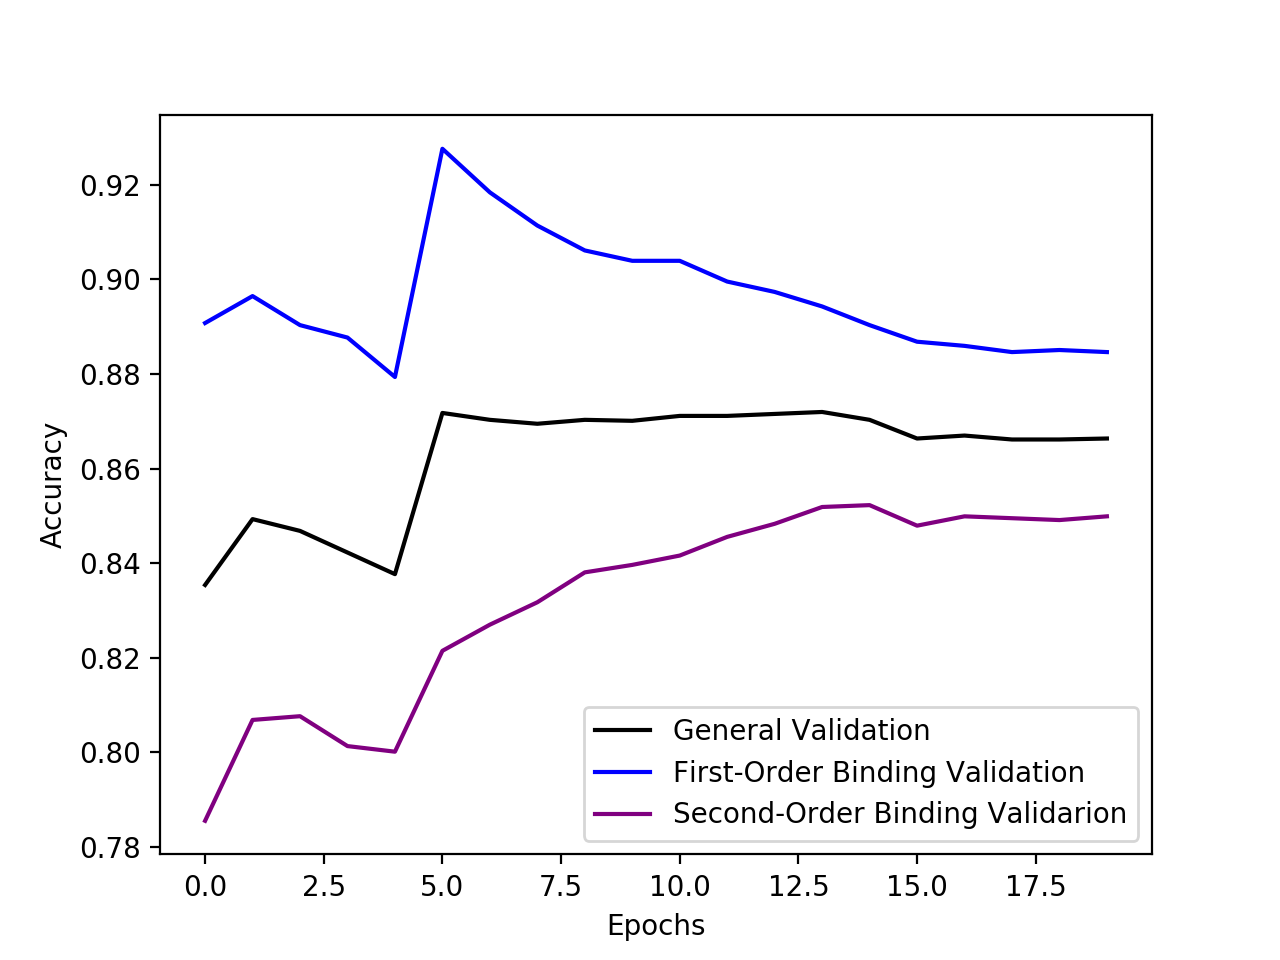

In [44]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600) #save image with high quality

plt.plot(Validation_a, label='General Validation',c='k')
plt.plot(Validation_1, label='First-Order Binding Validation',c='blue')
plt.plot(Validation_2, label='Second-Order Binding Validarion',c='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#fig.savefig('VALIDATION.png')

# Memory Validation

<IPython.core.display.Javascript object>


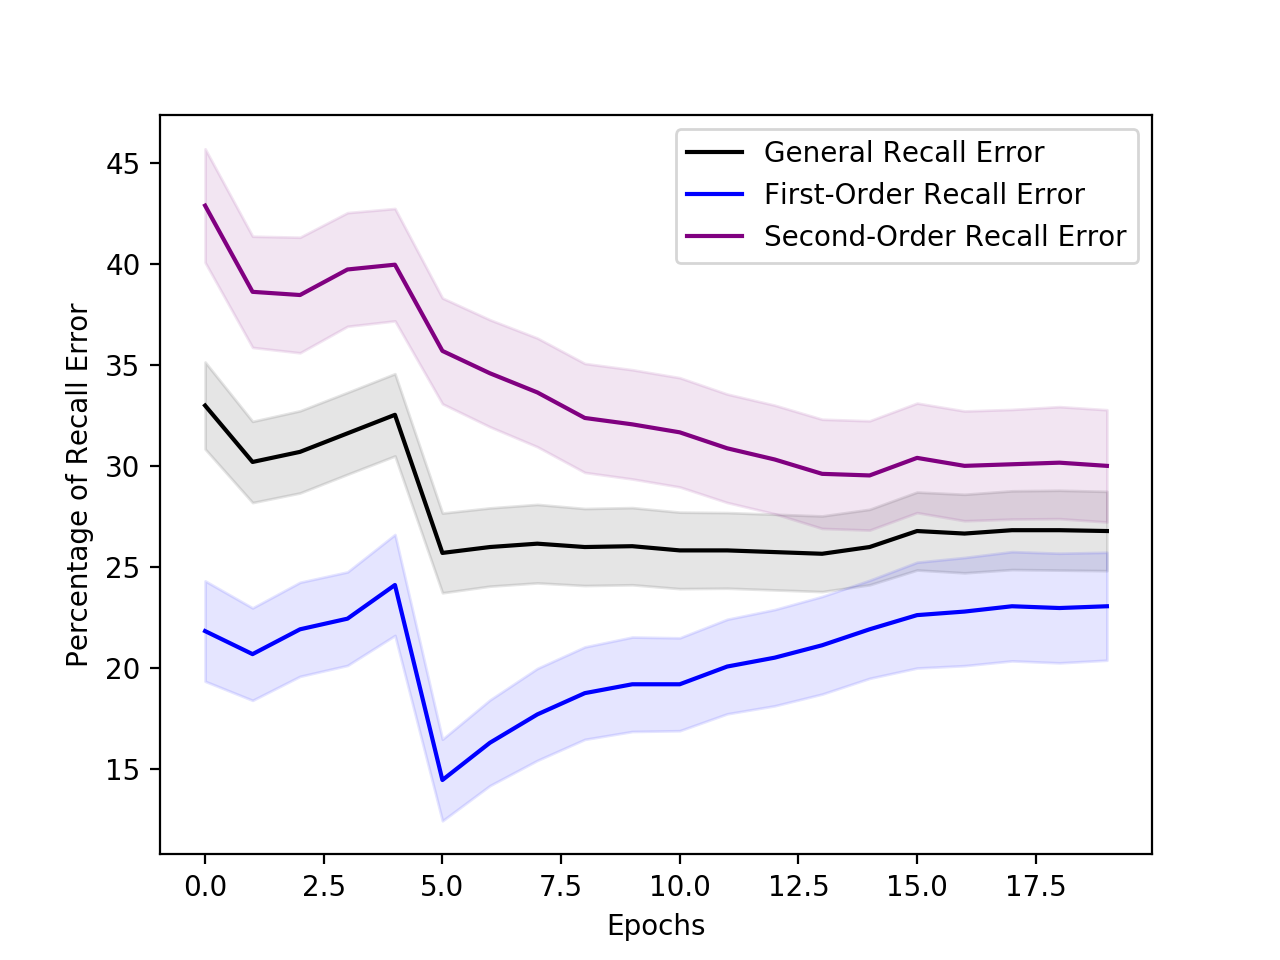

In [45]:
%matplotlib notebook
#fig = plt.figure(figsize=(6,5), dpi=600)
x=np.zeros(np.size(c_a[:,0]))
for i in range(np.size(c_a[:,0])):
    x[i]=i
#############################################################    



plt.plot(RECAL*100, label='General Recall Error',c='k')
plt.fill_between(x,L*100,U*100, alpha=.1, color='k')
plt.plot(RECAL1*100, label='First-Order Recall Error',c='blue')
plt.fill_between(x,L1*100,U1*100, alpha=.1, color='blue')
plt.plot(RECAL2*100, label='Second-Order Recall Error',c='purple')
plt.fill_between(x,L2*100,U2*100, alpha=.1, color='purple')
plt.xlabel('Epochs')
plt.ylabel('Percentage of Recall Error')
plt.legend()
plt.show()

#fig.savefig('Memory_Error.png')

## Pridiction

Predict on `new X_test`:

In [46]:
n=5
m=8

In [47]:
#for first
x_test=np.random.randint(0,2,(1,1,cols))
x_test[0,0,0]=0 #for one past
x_test[0,0,1]=0
temp=np.zeros((1,1,remembered*(cols-2)))
temp[0,0,:cols-2]=x_test[0,0,2:]
y_test=temp
########################################################################

for j in range(m):
    #X1_test
    for i in range(n):
        temp=np.random.randint(0,2,(1,1,cols))
        temp[0,0,0]=0
        temp[0,0,1]=0
        x_test=np.append(x_test,temp,axis=0)

    #Y1_test
    for i in range(n):
        t1=np.zeros((1,1,cols-2))
        t2=np.zeros((1,1,cols-2))
        t1[0,0,:]=x_test[j*2*n+i+1,0,2:]
        t2[0,0,:]=x_test[j*2*n+i,0,2:]
        temp=np.concatenate((t1[0],t2[0]),axis=1)
        y_test=np.append(y_test,temp.reshape(1,1,(cols-2)*remembered),axis=0)

    #X2_test
    for i in range(n):
        temp=np.random.randint(0,2,(1,1,cols))
        temp[0,0,0]=1
        temp[0,0,1]=1
        x_test=np.append(x_test,temp,axis=0)
    
    #Y2_test
    for i in range(n):
        t1=np.zeros((1,1,cols-2))
        t2=np.zeros((1,1,cols-2))
        t1[0,0,:]=x_test[j*2*n+n+i+1,0,2:]
        t2[0,0,:]=x_test[j*2*n+n+i-1,0,2:]
        temp=np.concatenate((t1[0],t2[0]),axis=1)
        y_test=np.append(y_test,temp.reshape(1,1,(cols-2)*remembered),axis=0)

#######################################################################
y_test[0,0,cols-2:]=x_val_last


In [48]:
v=[]
y_temp , v = dcwm(x_test[0]) 
y_pred=y_temp.numpy().reshape(1,2*(cols-2))
i=1
while i < 2*n*m:
    y_pred_temp , v = dcwm(x_test[i]) 
    y_pred=np.append(y_pred,y_pred_temp.numpy().reshape(1,2*(cols-2)),0)
    i=i+1
    
y_pred=y_pred.T

In [49]:
np.shape(y_pred)

(12, 80)

In [50]:
np.shape(v)

(15398, 1, 350)

the last is for test 2*(2*m*n), other for validation (model save IV history for next works)

## Plot Data Remembering

<IPython.core.display.Javascript object>


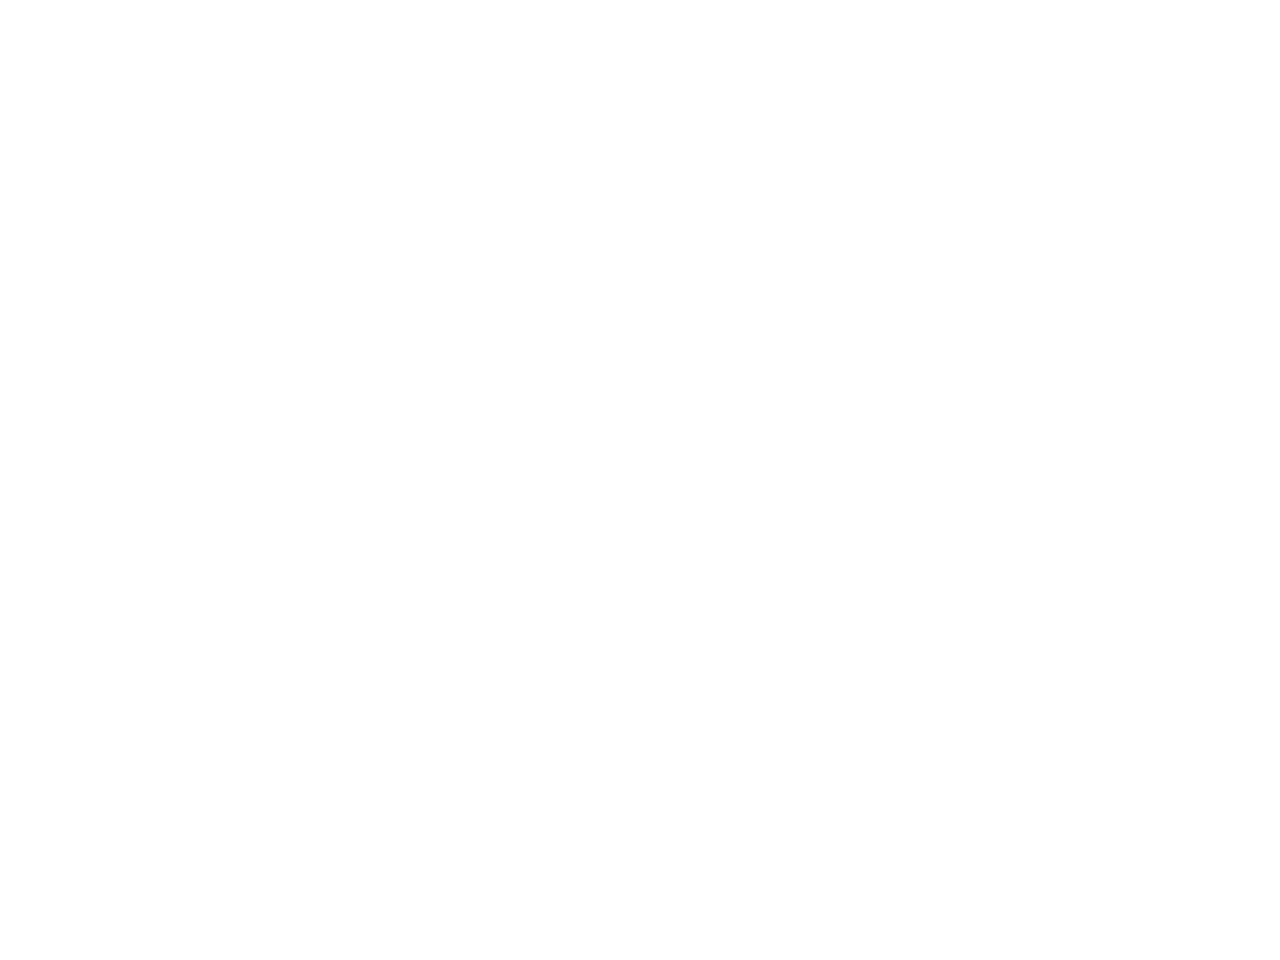

In [51]:
%matplotlib notebook
#fig = plt.figure(figsize=(10,5), dpi=300)

copy = np.full(y_pred.shape, np.nan)
rem1 = np.full(y_pred.shape, np.nan)
rem2 = np.full(y_pred.shape, np.nan)
copy[:cols-2,:] = y_pred[:cols-2,:]

for t in range(m):
        rem1[cols-2:,t*2*n:t*2*n+n+1] = y_pred[cols-2:,t*2*n:t*2*n+n+1]
        rem2[cols-2:,t*2*n+n+1:(t+1)*2*n+1] = y_pred[cols-2:,t*2*n+n+1:(t+1)*2*n+1]

plt.imshow(copy,cmap='Greys')
plt.imshow(rem1,cmap='Blues')
plt.imshow(rem2,cmap='Purples')

#fig.savefig('Multi-task.png')

In [52]:
y_decide=np.zeros(y_pred.shape)
for i in range(2*(cols-2)):
    for j in range(2*n*m):
        if y_pred[i,j]>(1/2) : # thereshold 0.5
           y_decide[i,j]=1

<IPython.core.display.Javascript object>


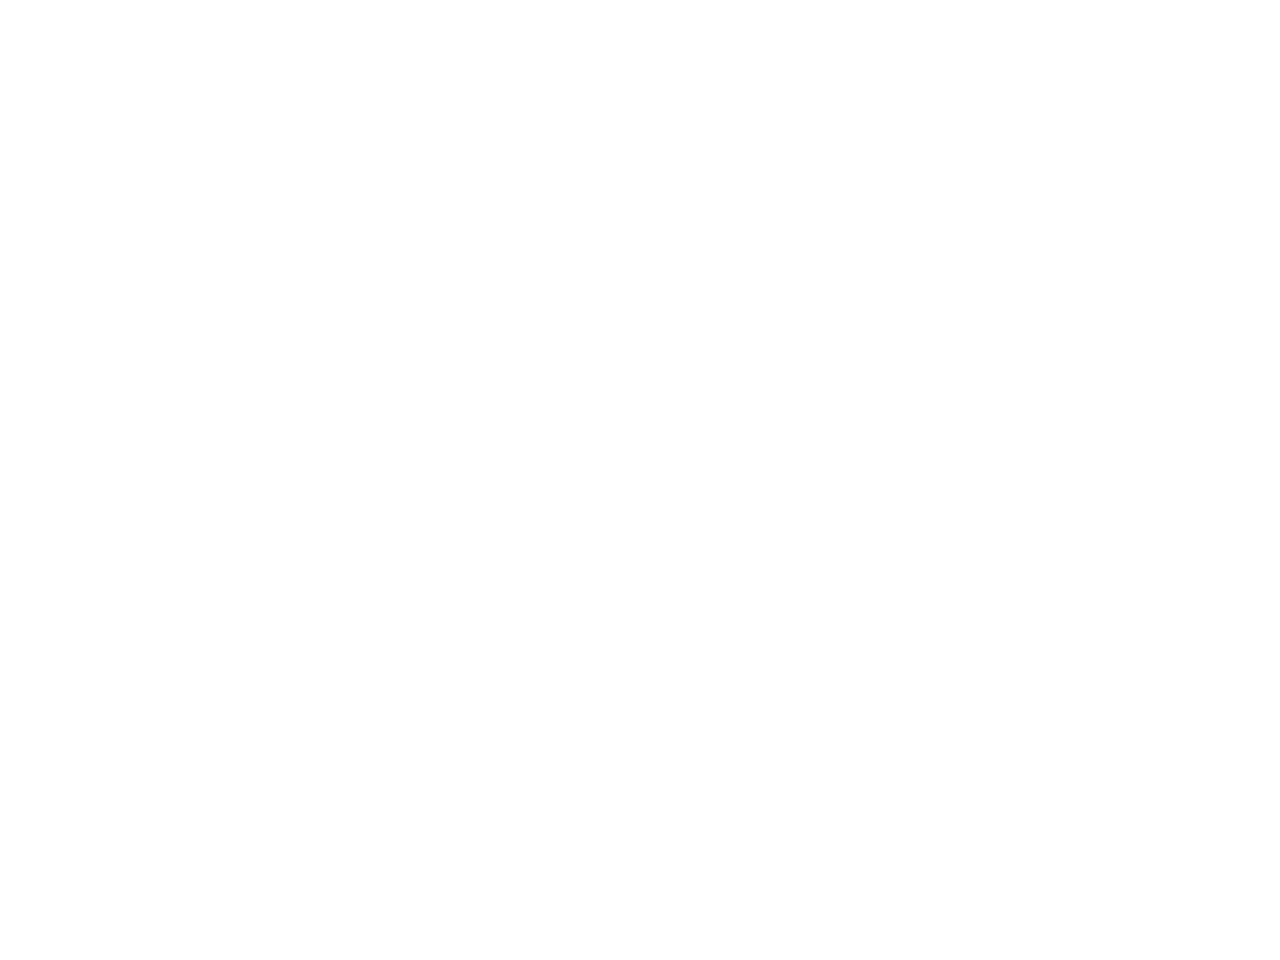

In [53]:
%matplotlib notebook
#fig = plt.figure(figsize=(10,5), dpi=100)


copy = np.full(y_decide.shape, np.nan)
pre_rem1 = np.full(y_decide.shape, np.nan)
pre_rem2 = np.full(y_decide.shape, np.nan)
copy[:cols-2,:] = y_decide[:cols-2,:]

for t in range(m):
        pre_rem1[cols-2:,t*2*n:t*2*n+n+1] = y_decide[cols-2:,t*2*n:t*2*n+n+1]
        pre_rem2[cols-2:,t*2*n+n+1:(t+1)*2*n+1] = y_decide[cols-2:,t*2*n+n+1:(t+1)*2*n+1]

plt.imshow(copy,cmap='Greys')
plt.imshow(pre_rem1,cmap='Blues')
plt.imshow(pre_rem2,cmap='Purples')


#fig.savefig('DecideMulti.png')

In [54]:
y_test_show=np.zeros(((cols-2)*remembered,2*n*m))
for i in range((cols-2)*remembered):
    for j in range(2*n*m):
        y_test_show[i,j]=y_test[j,0,i]

<IPython.core.display.Javascript object>


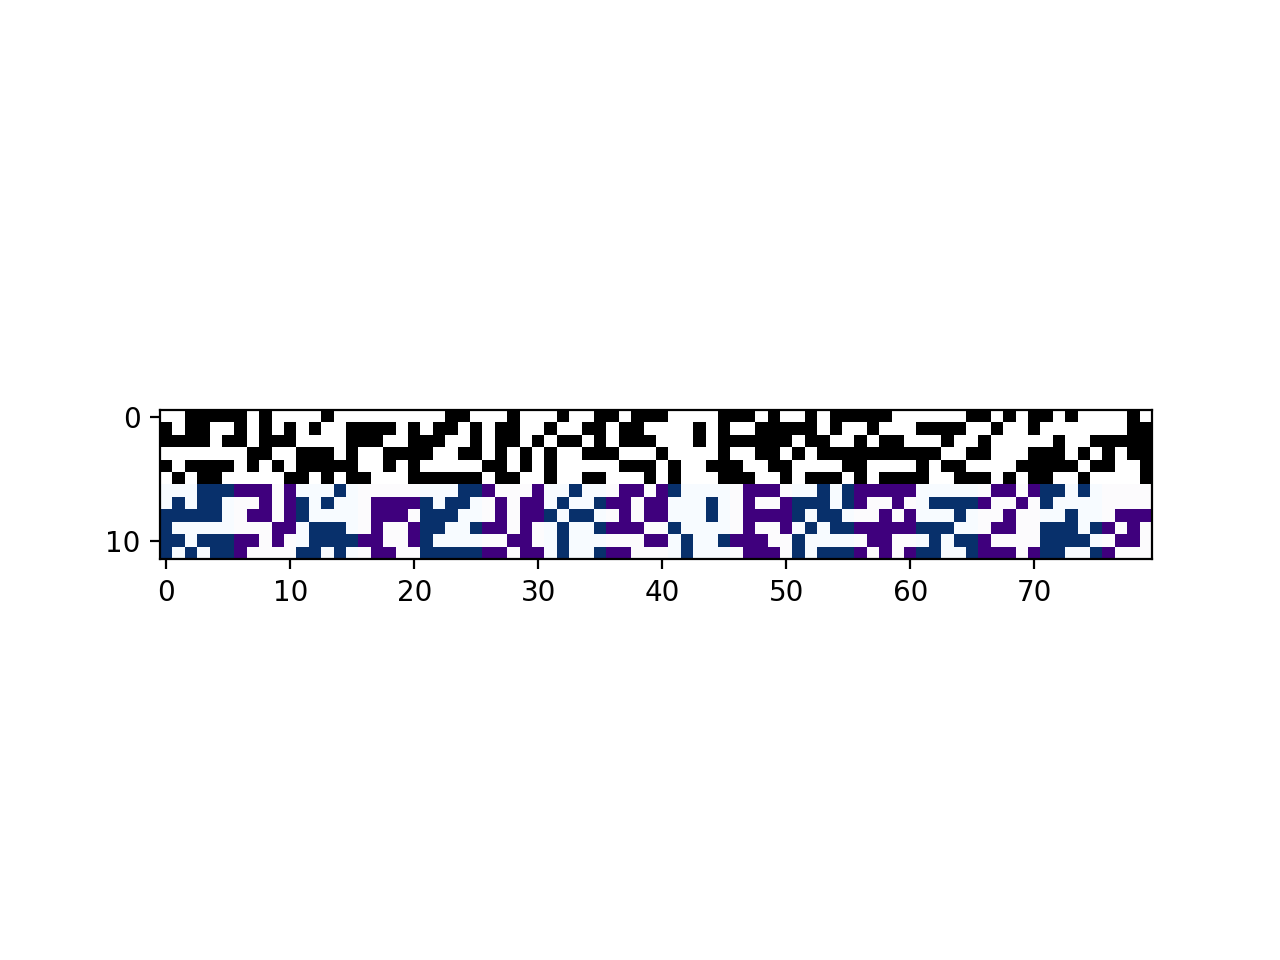

In [55]:
#showing Real y_test
%matplotlib notebook
copy = np.full(y_test_show.shape, np.nan)
real_rem1 = np.full(y_test_show.shape, np.nan)
real_rem2 = np.full(y_test_show.shape, np.nan)
copy[:cols-2,:] = y_test_show[:cols-2,:]

for t in range(m):
        real_rem1[cols-2:,t*2*n:t*2*n+n+1] = y_test_show[cols-2:,t*2*n:t*2*n+n+1]
        real_rem2[cols-2:,t*2*n+n+1:(t+1)*2*n+1] = y_test_show[cols-2:,t*2*n+n+1:(t+1)*2*n+1]

plt.imshow(copy,cmap='Greys')
plt.imshow(real_rem1,cmap='Blues')
plt.imshow(real_rem2,cmap='Purples')

<IPython.core.display.Javascript object>


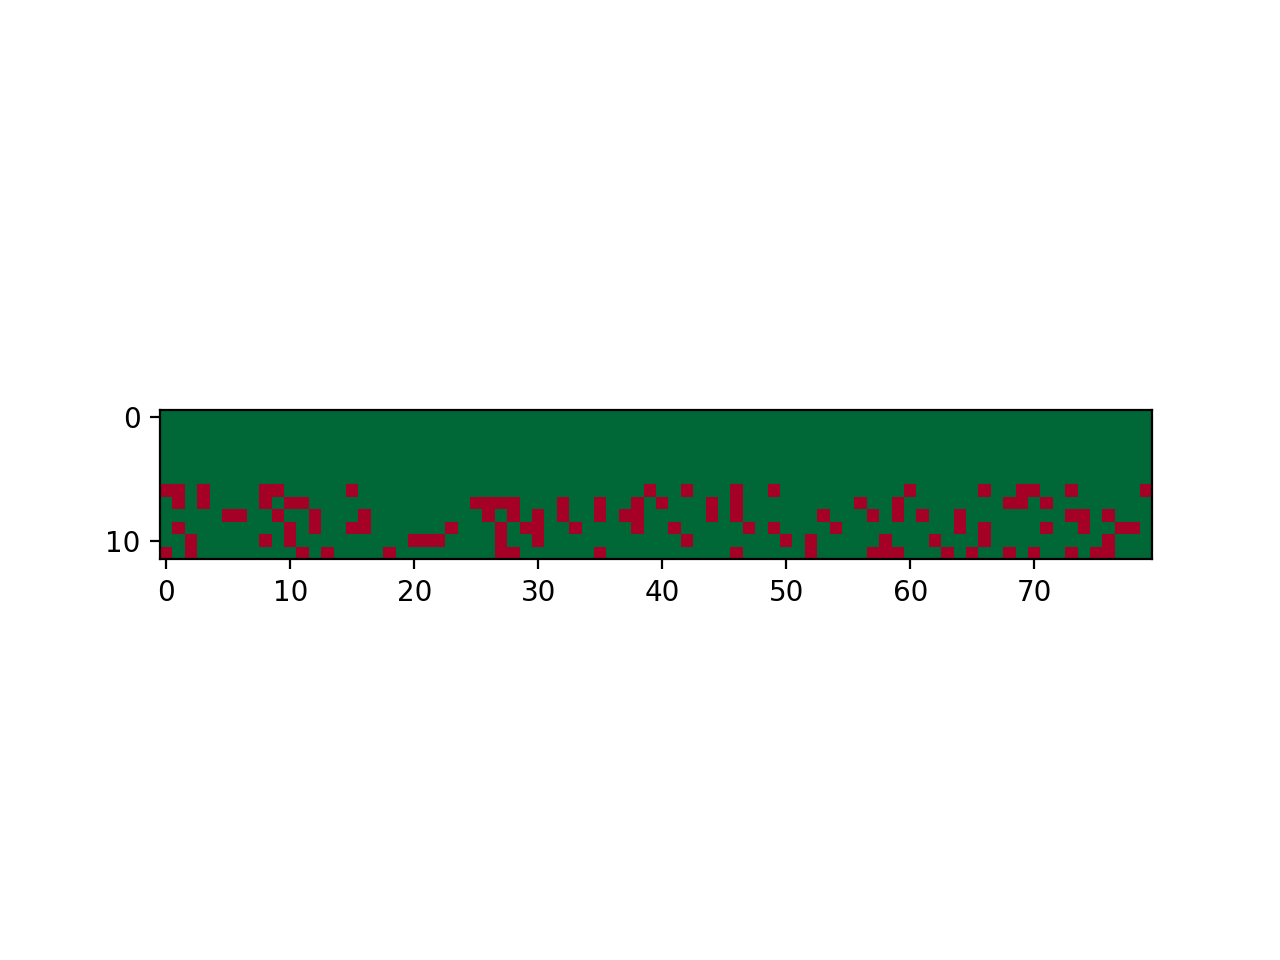

In [56]:
%matplotlib notebook
#fig = plt.figure(figsize=(10,5), dpi=300)


ER = np.full(y_test_show.shape, np.nan)


for i in range(2*(cols-2)):
    for j in range(2*m*n):
        if (y_decide[i,j]==y_test_show[i,j]):
            ER[i,j]=1
        else:
            ER[i,j]=0
            

plt.imshow(ER,cmap='RdYlGn')


#fig.savefig('remmember_trace.png')

## Interface Vector Implimentiont

In [57]:
v[0][0][0] #how work with vector

0.23949144944125217

In [58]:
bit=np.zeros((interface_vactor_dim,(2*2*n*m)))
for i in range(2*(2*n*m)):
    for j in range(interface_vactor_dim):
        bit[j,i]=v[-2*2*n*m+i][0][j]

<IPython.core.display.Javascript object>


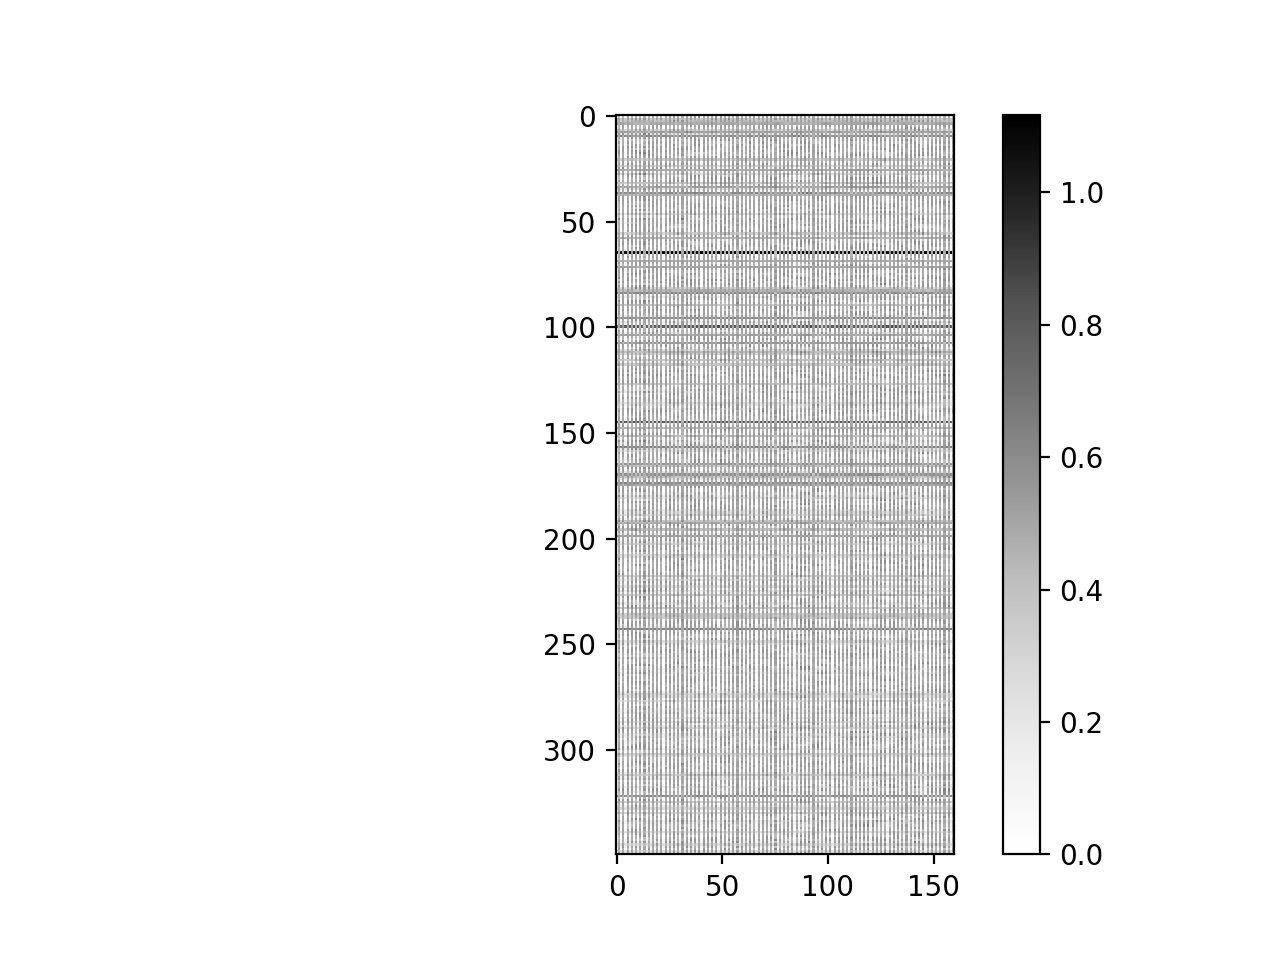

In [59]:
%matplotlib notebook 
plt.imshow(bit,cmap='Greys')
plt.colorbar()

<IPython.core.display.Javascript object>


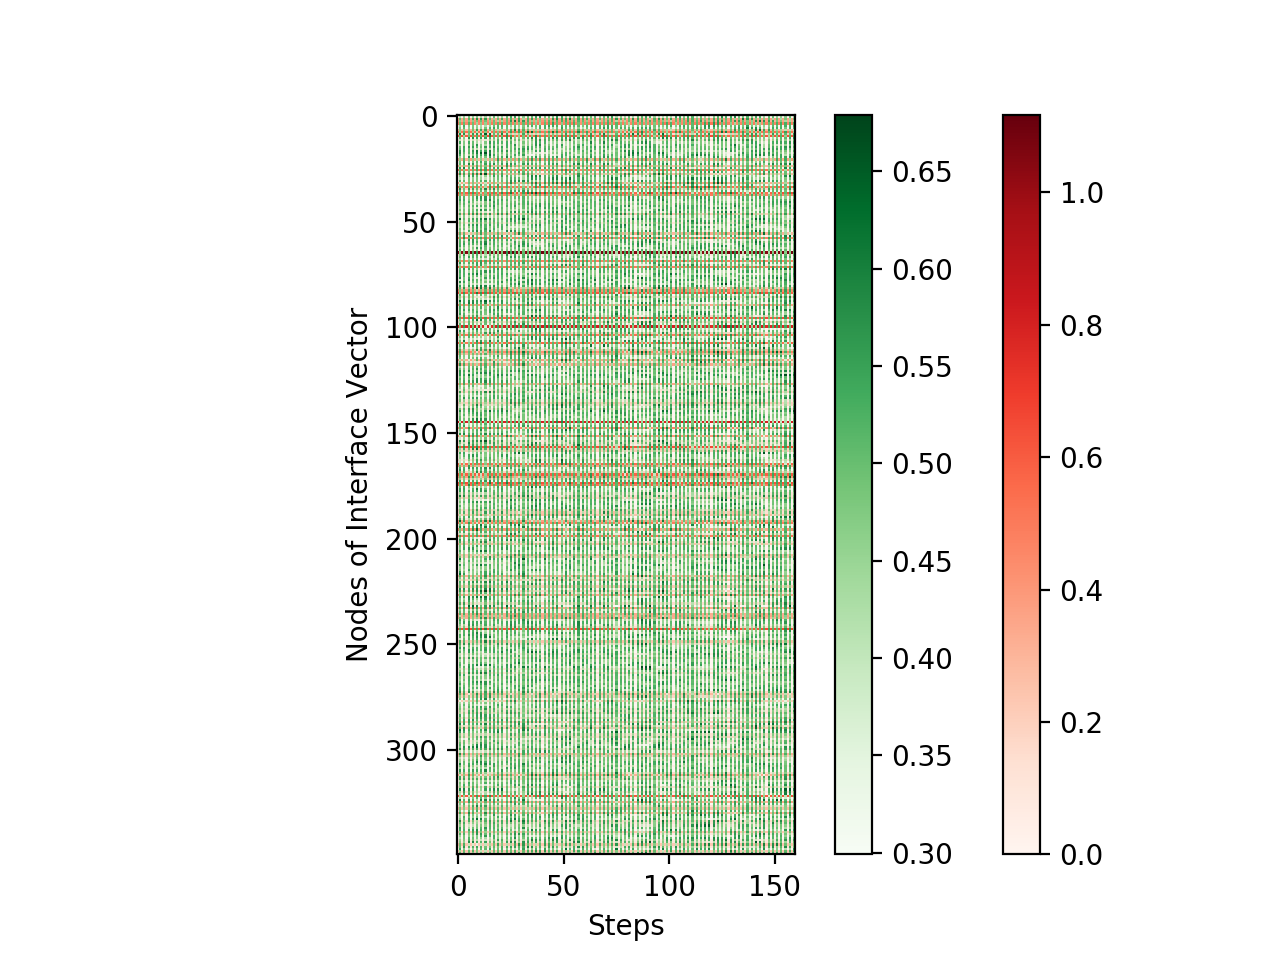

Text(0, 0.5, 'Nodes of Interface Vector')

In [60]:
%matplotlib notebook
#fig = plt.figure(figsize=(5,5), dpi=600) #saving high quality

write = np.full(bit.shape, np.nan)
read = np.full(bit.shape, np.nan)
read[:,::2] = bit[:,::2]
write[:,1::2] = bit[:,1::2]
plt.imshow(read,cmap='Reds')
plt.colorbar()
plt.imshow(write,cmap='Greens')
plt.colorbar()
plt.xlabel("Steps")
plt.ylabel("Nodes of Interface Vector")

#fig.savefig('Read_write.png')

In [61]:
%matplotlib notebook
read_sep=np.zeros(shape=(interface_vactor_dim,2*n*m))
write_sep=np.zeros(shape=(interface_vactor_dim,2*n*m))
read_sep[:,::]=bit[:,::2]
write_sep[:,::]=bit[:,1::2]

### Read Vectro from  RN to Use in current step

<IPython.core.display.Javascript object>


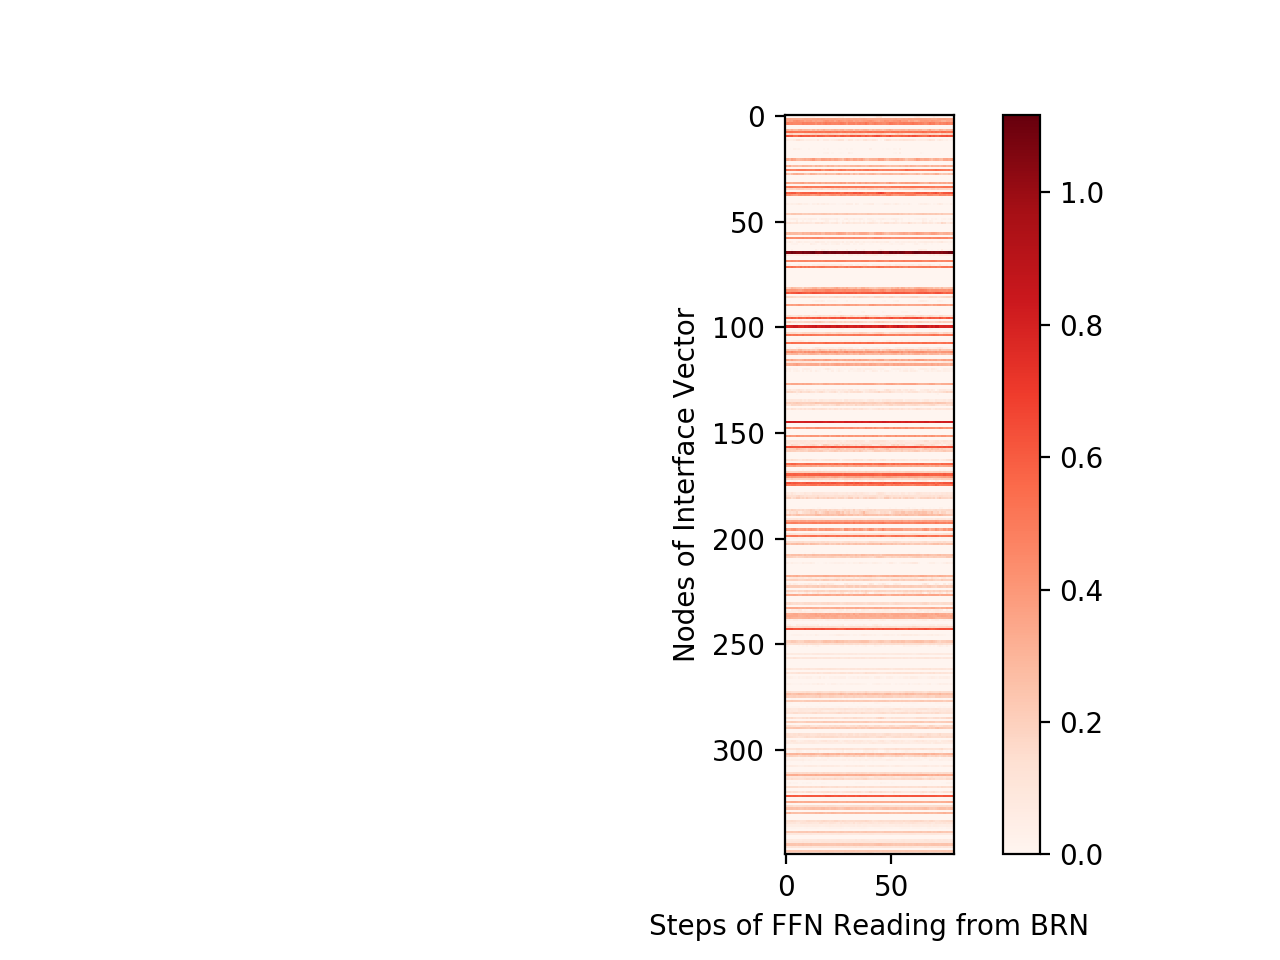

Text(0, 0.5, 'Nodes of Interface Vector')

In [62]:
%matplotlib notebook
#fig = plt.figure(figsize=(5,5), dpi=600)

plt.imshow(read_sep,cmap='Reds')
plt.colorbar()
plt.xlabel("Steps of FFN Reading from BRN")
plt.ylabel("Nodes of Interface Vector")

#fig.savefig('Read_from_BRN_vector.png')

### Write Vector to RN for Next step

<IPython.core.display.Javascript object>


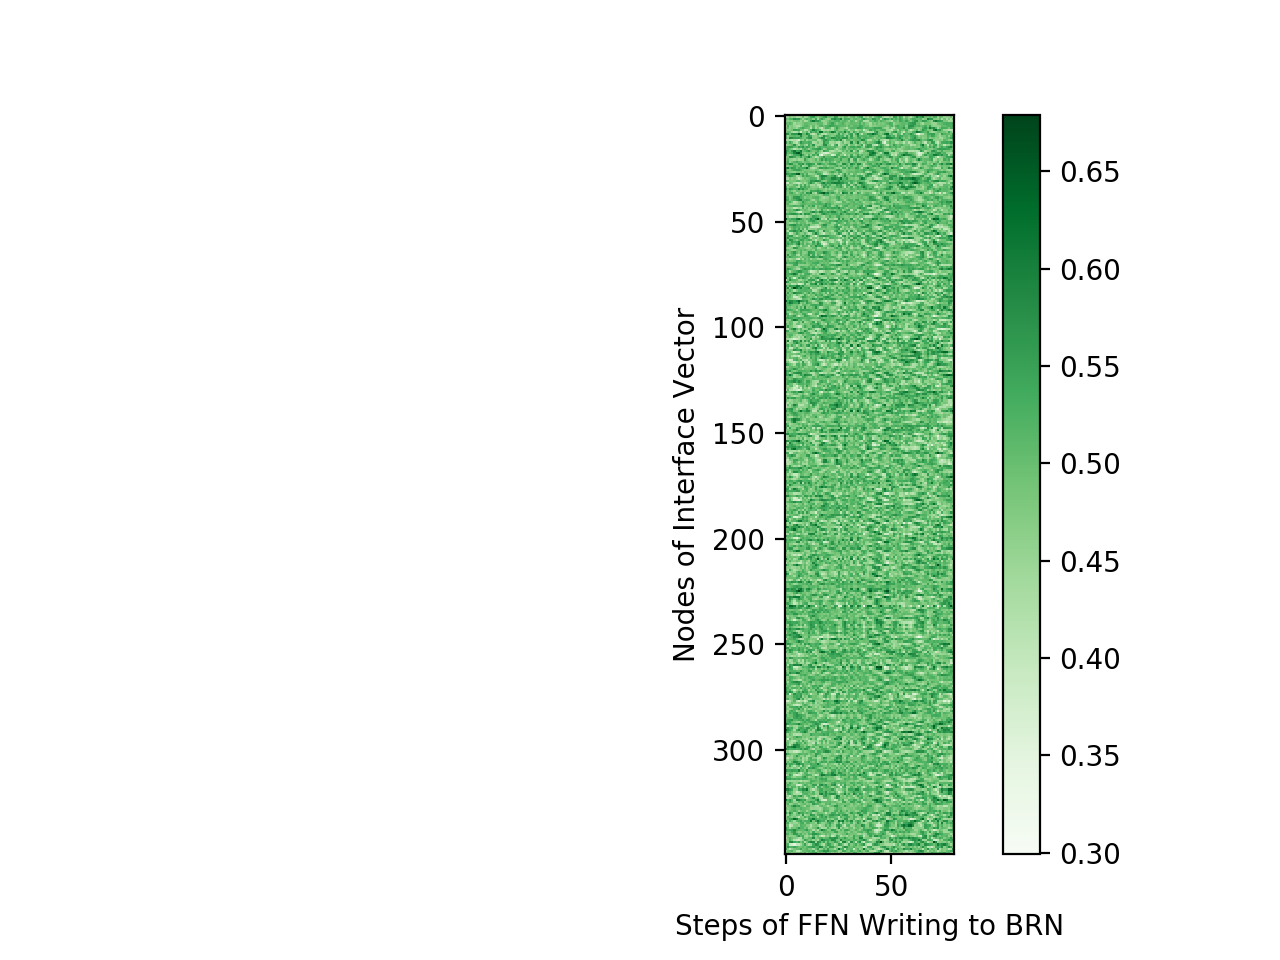

Text(0, 0.5, 'Nodes of Interface Vector')

In [63]:
%matplotlib notebook
#fig = plt.figure(figsize=(5,5), dpi=600)

plt.imshow(write_sep,cmap='Greens')
plt.colorbar()
plt.xlabel("Steps of FFN Writing to BRN")
plt.ylabel("Nodes of Interface Vector")

#fig.savefig('write_to_BRN_vector.png')

# Model Summery

In [64]:
dcwm.summary()

Model: "dcwm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dcwm_controller (Dense)      multiple                  183808    
_________________________________________________________________
dcwm_controller (Dense)      multiple                  525312    
_________________________________________________________________
dcwm_controller (Dense)      multiple                  524800    
_________________________________________________________________
dcwm_controller (Dense)      multiple                  185706    
Total params: 1,550,670
Trainable params: 1,419,626
Non-trainable params: 131,044
_________________________________________________________________
